In [17]:
import pandas as pd
import numpy as np
from numpy import array
from skimage.io import imshow
from sklearn import metrics as mt
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
import seaborn as sns
from keras.models import load_model

In [2]:
train = pd.read_pickle("./Data/train.pickle")
test = pd.read_pickle("./Data/test.pickle")
classes = open('./Data/classes.txt', 'r').read().split()

img_wh = 50

For some reason, the extract.py script left some pixel values as greater than 0 but less than 1.

In [3]:
# put more instances in testing to make it an 80/20 split
split = int((len(train) + len(test)) * .8)
test = np.append(test, train[split:])
train = train[:split-1]

In [4]:
X_train = []
X_test = []
y_train = []
y_test = []
y_train_ohe = []
y_test_ohe = []

for elem in train:
    X_train.append(elem['features'])
    y_train.append(np.argmax(elem['label'], axis=0))
    y_train_ohe.append(elem['label'])
    
for elem in test:
    X_test.append(elem['features'])
    y_test.append(np.argmax(elem['label'], axis=0))
    y_test_ohe.append(elem['label'])
    
X_train = array(X_train).reshape((-1,img_wh,img_wh,1))
y_train = array(y_train)
y_train_ohe = array(y_train_ohe)
X_test = array(X_test).reshape((-1,img_wh,img_wh,1))
y_test = array(y_test)
y_test_ohe = array(y_test_ohe)

NUM_CLASSES = len(y_train_ohe[0])

In [5]:
print(X_train.shape)
print(X_test.shape)
print(y_train_ohe.shape)
print(y_test_ohe.shape)

(121192, 50, 50, 1)
(30299, 50, 50, 1)
(121192, 17)
(30299, 17)


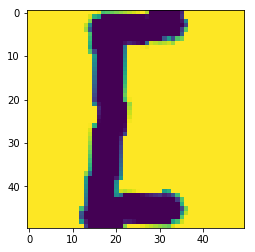

class: [


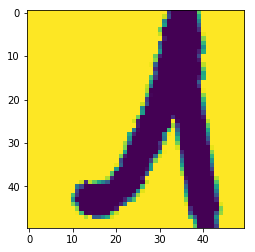

class: 1


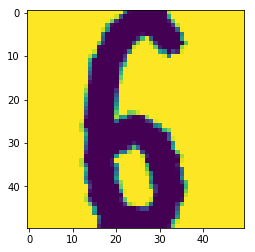

class: 6


In [6]:
for i in range(3):
    plt.imshow(X_train[i].squeeze())
    plt.show()
    print("class: " + classes[y_train[i]])

In [13]:
%%time 

datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None)

datagen.fit(X_train)

cnn = Sequential()

cnn.add(Conv2D(filters=32,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax

cnn.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
    

# add one layer on flattened output
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transformations
cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                   steps_per_epoch=int(len(X_train)/1024), # how many generators to go through per epoch
                   epochs=5, verbose=5,
                   validation_data=(X_test,y_test_ohe)
                  )



Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
CPU times: user 1h 17min 5s, sys: 7min 1s, total: 1h 24min 7s
Wall time: 23min 45s


In [14]:
def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes)
    plt.title(title_text+'{:.4f}'.format(acc))
    plt.show()

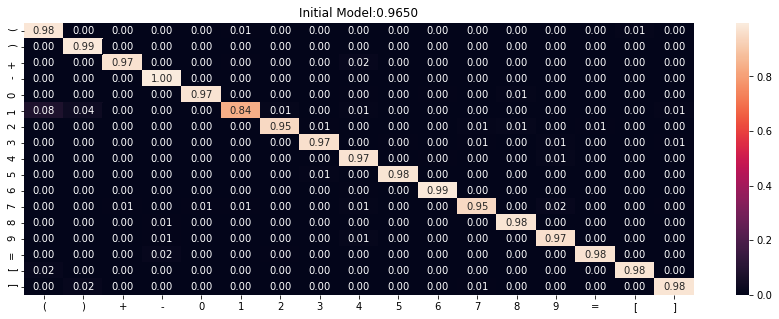

In [15]:
summarize_net(cnn, X_test, y_test, title_text='Initial Model:')

In [19]:
cnn.save('cnn_11_3.h5')